# Instalando a biblioteca Boto3

In [ ]:
!pip install boto3

#Importando todas as bibliotecas usadas

In [ ]:
import boto3
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams as mpl_param
from PIL import Image, ImageDraw
import re
import difflib


#Acessos AWS

Utilizamos o AWS como provedor.
Serviços: Textextract e Rekognition

In [ ]:
ACCESS_ID = "hide"
ACCESS_KEY = "hide"
region = "us-east-1"

In [ ]:
mpl_param["figure.dpi"] = 200 ## Configurando o Matplotlib para gerar figuras com uma resolução maior

#Obtendo a CNH

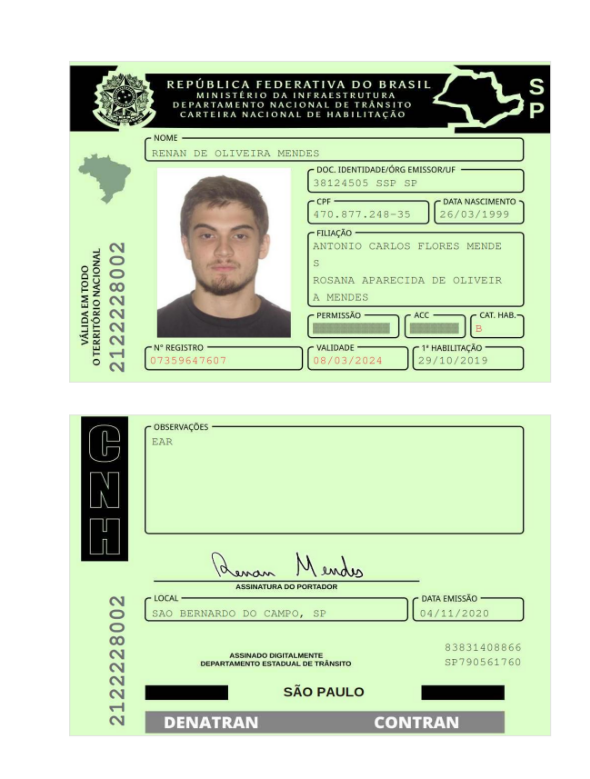

In [ ]:
img = mpimg.imread("/content/CNH.png")
imgplot = plt.imshow(img)

plt.axis('off')
plt.show()

#Função para extrair o nome e o CPF

In [ ]:
def processar_arquivo(file_name):
    # Visualizando a imagem
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()


    # Transformando em bytes
    with open(file_name, "rb") as file:
        img_test = file.read()
        bytes_test = bytearray(img_test)

    # Configurando o  Textract
    session = boto3.Session(aws_access_key_id=ACCESS_ID, aws_secret_access_key=ACCESS_KEY)
    client = session.client('textract', region_name=region)
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    blocks = response["Blocks"]

    nome = None
    cpf = None
    face_img = None
    capturar_nome = False
    nome_completo = []

    # Abrindo a imagem para recorte
    original_image = Image.open(file_name)

    # Extraindo o nome e CPF
    for i, block in enumerate(blocks):
        if block["BlockType"] == "WORD" and int(block["Confidence"]) > 50:
            text = block["Text"]

            # Detectar início do nome
            if "NOME" in text.upper():
                capturar_nome = True
                continue

            # Capturar o nome completo até encontrar "DOC"
            if capturar_nome:
                if "DOC" in text.upper():
                    capturar_nome = False
                else:
                    nome_completo.append(text)

            # Capturar o CPF com regex
            if re.match(r'\d{3}\.\d{3}\.\d{3}-\d{2}', text):
                cpf = text

    nome = " ".join(nome_completo) if nome_completo else None

    # Exibir resultados
    print(f"NOME COMPLETO: {nome}")
    print(f"CPF: {cpf}")

    return nome, cpf


Testando a função:

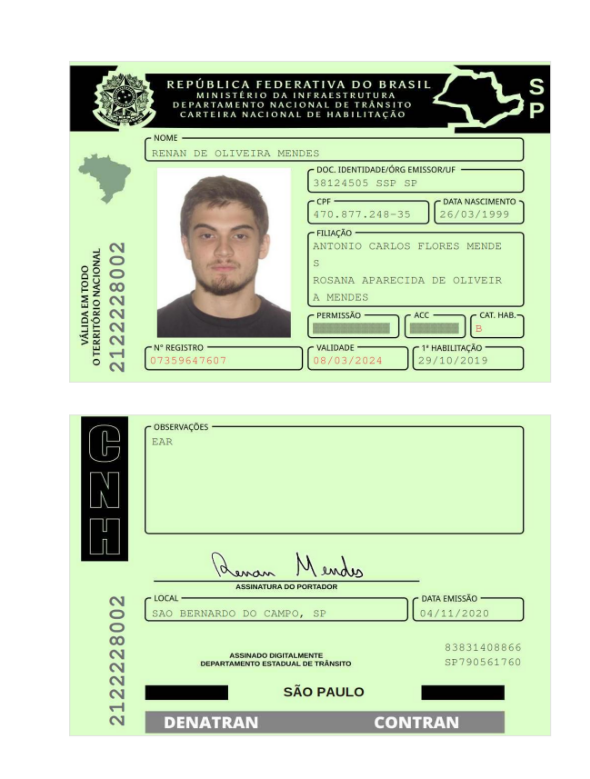

NOME COMPLETO: RENAN DE OLIVEIRA MENDES
CPF: 470.877.248-35


In [ ]:
nome_completo, cpf = processar_arquivo("/content/CNH.png")

In [ ]:
nome_completo

'RENAN DE OLIVEIRA MENDES'

In [ ]:
cpf

'470.877.248-35'

#Função para extrair a face da CNH

In [ ]:
def detectar_face(file_name):
    # Ler a imagem em bytes
    with open(file_name, "rb") as file:
        img_bytes = file.read()

    # Configurando o Rekognition
    session = boto3.Session(aws_access_key_id=ACCESS_ID, aws_secret_access_key=ACCESS_KEY)
    client = session.client('rekognition', region_name=region)

    # Detectando faces na imagem
    response = client.detect_faces(
        Image={'Bytes': img_bytes},
        Attributes=['DEFAULT']
    )

    original_image = Image.open(file_name)

    face_img = None

    # Verificando se encontrou algum rosto
    if response['FaceDetails']:
        face = response['FaceDetails'][0]  # Pegar a face encontrada

        bbox = face['BoundingBox']

        # Calcular as coordenadas
        img_width, img_height = original_image.size
        left = int(bbox['Left'] * img_width)
        top = int(bbox['Top'] * img_height)
        width = int(bbox['Width'] * img_width)
        height = int(bbox['Height'] * img_height)

        # Recortar a face
        face_img = original_image.crop((left, top, left + width, top + height))
        print("Face localizada")

    return face_img


Testando a função

Face localizada


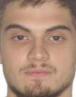

In [ ]:
detectar_face("/content/CNH.png")

#Pegando a imagem para comparação

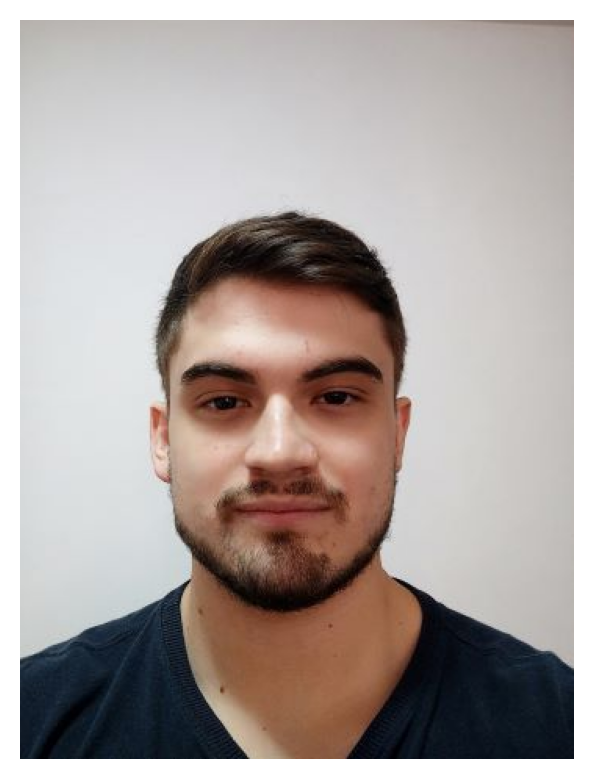

In [ ]:
img = mpimg.imread("/content/Foto neutra 3x4.jpg")
imgplot = plt.imshow(img)

plt.axis('off')
plt.show()

#Função de comparação de imagens

## Essa função compara duas imagens e retorna a similaridade.

In [ ]:
def comparar_faces(imagem_origem, imagem_destino):
    with open(imagem_origem, "rb") as source_image, open(imagem_destino, "rb") as target_image:
        source_bytes = source_image.read()
        target_bytes = target_image.read()

    session = boto3.Session(aws_access_key_id=ACCESS_ID, aws_secret_access_key=ACCESS_KEY)
    client = session.client('rekognition', region_name=region)

    response = client.compare_faces(
        SourceImage={'Bytes': source_bytes},
        TargetImage={'Bytes': target_bytes},
        SimilarityThreshold=70
    )

    if response['FaceMatches']:
        match = response['FaceMatches'][0]
        similarity = match['Similarity']
        box = match['Face']['BoundingBox']

        # Abrir a imagem de destino
        img = Image.open(imagem_destino)
        draw = ImageDraw.Draw(img)
        img_width, img_height = img.size

        # Calcular as coordenadas
        left = int(box['Left'] * img_width)
        top = int(box['Top'] * img_height)
        width = int(box['Width'] * img_width)
        height = int(box['Height'] * img_height)

        # Desenhar o retângulo e a porcentagem de similaridade
        draw.rectangle([(left, top), (left + width, top + height)], outline="#00d400")

        # Adicionar o texto com a porcentagem de similaridade
        font = ImageFont.load_default()
        text = f"Similaridade: {similarity:.2f}%"
        draw.text((left, top - 20), text, font=font)

        # Salvar a imagem final
        img.save("face_comparada.jpg")
        img.show()

        print(f"Similaridade encontrada: {similarity:.2f}%")
        return similarity
    else:
        print("Nenhuma face correspondente encontrada.")
        return 0




Testando

In [ ]:
comparar_faces("/content/CNH.png", "/content/Foto neutra 3x4.jpg")

Similaridade encontrada: 100.00%


99.9976806640625

##Geramos a imagem nova com o bloco de similaridade

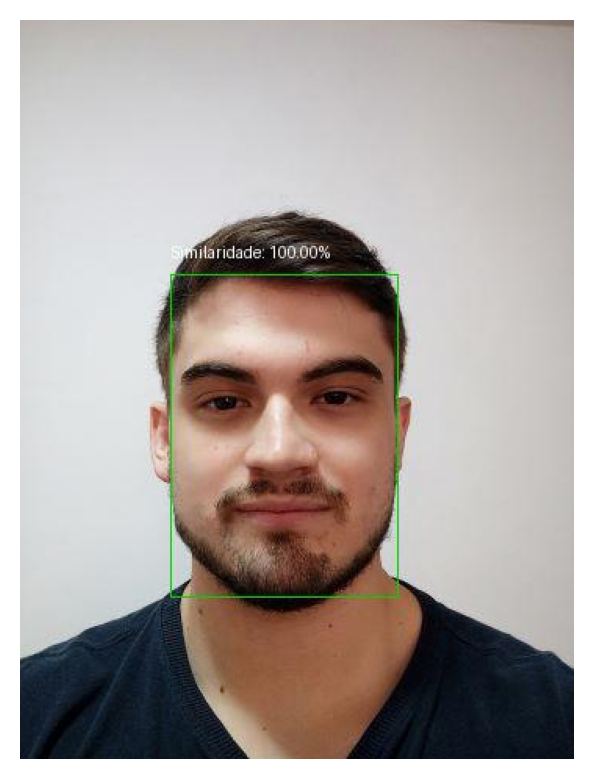

In [ ]:
img = mpimg.imread("/content/face_comparada.jpg")
imgplot = plt.imshow(img)

plt.axis('off')
plt.show()

#Função de Extração e Comparação.
###Esssa função extrai o nome e endereço de uma conta de luz.
###Também realiza a comparação com a váriavel nome identificada no documento da CNH

In [ ]:
def extrair_nome_endereco(file_name):
    """Extrai o nome e o endereço de uma conta de luz com Textract."""
    with open(file_name, "rb") as file:
        img_bytes = file.read()

    session = boto3.Session(aws_access_key_id=ACCESS_ID, aws_secret_access_key=ACCESS_KEY)
    client = session.client('textract', region_name=region)

    response = client.analyze_document(
        Document={'Bytes': img_bytes},
        FeatureTypes=['FORMS']
    )

    blocks = response['Blocks']
    nome, endereco = "", ""
    capturar_nome, capturar_endereco = False, False

    for i, block in enumerate(blocks):
        if block['BlockType'] == 'WORD':
            texto = block['Text'].strip()

            # Capturar o nome após PAGADOR/CPF e antes de CPF
            if texto.lower() == 'pagador/cpf':
                capturar_nome = True
                capturar_endereco = False
                continue
            if texto.lower() == 'cpf:':
                capturar_nome = False
                continue

            if capturar_nome:
                nome += texto + " "

             # Capturar o endereço começando com Rua ou Avenida e indo até DATA
            if texto.lower() in ['AV']:
                capturar_endereco = True
                endereco += texto + " "
                continue
            if texto.lower() == 'DATA':
                capturar_endereco = False
                continue

            if capturar_endereco:
                endereco += texto + " "

    return nome.strip(), endereco.strip()


# Função de comparação de nomes
def comparar_nomes(nome_cnh, nome_conta):
    """Compara os nomes com uma métrica de similaridade."""
    similaridade = difflib.SequenceMatcher(None, nome_cnh.lower(), nome_conta.lower()).ratio()
    return similaridade * 100



In [ ]:
nome_conta, endereco_conta = extrair_nome_endereco("/content/comprovante de residencia_page-0002.jpg")
# Access the name element of the tuple (index 0)
similaridade = comparar_nomes(nome_completo, nome_conta)

In [ ]:
similaridade

100.0